# Machine learning Project----automatic music genre classification

## MainGoal: Music genre classification 

Data Resource:  "GTZAN Genre Collection" with 10 genres and 100 tracks in each class.

Resource Website:   http://marsyasweb.appspot.com/download/data_sets/

## Procedures:

1.Features extration from the audio files

Using library librosa to which has many useful functions for music feature extraction. 

Features we used in this demo include mfccs, chroma energy,tempo(BPM), RMSE and ZCR. For mfccs and chroma, it should be a 2D matrix, but we didn't use the whole matrix instead we take the mean value over time as our features. 

2.Traning and Testing

For each class, we have a 100(tracks)*35(feature values) data matrix.For it takes quite a while to extract features, so we save the matrixes into .mat files. So we don't need to run the extraction process over again.
  
We 'vstack' the 10 matrixes into one as X, and we label each class(blues=0, classical=1...rock=9) to generate a label vector y. Function 'train_test_split' in sklearn is used to divide X and y in to train and test sets. We used 800 samples for training and 200 for testing. Xtr and Xts are normalized over columns before training.

Multilayer Perceptron (MLP) was used for our multi-class softmax classification. We have print the model summary in this demo. We use Adam(lr=0.001) as optimizer and 'sparse_categorical_crossentropy' as loss function.


## Experiment Results:

   We set the batch size to 20 and train for 100 epochs, the validation accuracy reaches around 0.7.

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import librosa
import librosa.display
import librosa.feature

In [4]:
y, sr = librosa.load('./genres/jazz/jazz.00091.au')

(128, 1293)

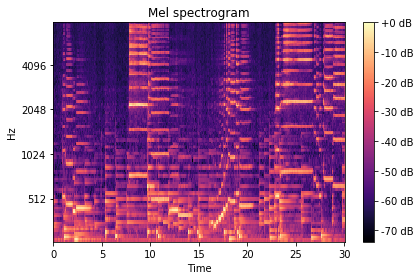

In [5]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmin=20, fmax=10000)
librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
S.shape

In [6]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo

array([ 117.45383523])

In [7]:
librosa.feature.zero_crossing_rate(y)

array([[ 0.03417969,  0.04052734,  0.04980469, ...,  0.28515625,
         0.25976562,  0.18359375]])

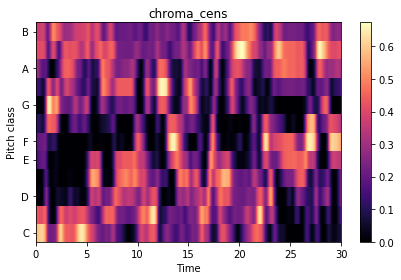

In [8]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
chroma_cens.shape
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()
plt.tight_layout()


In [9]:
# track listening
import IPython.display as ipd
ipd.Audio(y, rate=sr) # load a NumPy array

In [10]:
import scipy.io as sio

In [11]:
blues_data = sio.loadmat('blues_data.mat')['blues_data']
classical_data = sio.loadmat('classical_data.mat')['classical_data']
country_data = sio.loadmat('country_data.mat')['country_data']
disco_data = sio.loadmat('disco_data.mat')['disco_data']
hiphop_data = sio.loadmat('hiphop_data.mat')['hiphop_data']
jazz_data = sio.loadmat('jazz_data.mat')['jazz_data']
metal_data = sio.loadmat('metal_data.mat')['metal_data']
pop_data = sio.loadmat('pop_data.mat')['pop_data']
reggae_data = sio.loadmat('reggae_data.mat')['reggae_data']
rock_data = sio.loadmat('rock_data.mat')['rock_data']

In [61]:
Xy=np.vstack((blues_data,classical_data,country_data,disco_data,hiphop_data,jazz_data
...              ,metal_data,pop_data,reggae_data,rock_data))
#blues_data,classical_data,country_data,disco_data,hiphop_data,jazz_data,metal_data,pop_data,reggae_data,rock_data
Xy.shape

(1000, 35)

In [62]:
X = Xy
y=np.zeros(1000)
for i in range(100):
    y[i]=0
    y[100+i]=1
    y[200+i]=2
    y[300+i]=3
    y[400+i]=4
    y[500+i]=5
    y[600+i]=6
    y[700+i]=7
    y[800+i]=8
    y[900+i]=9


In [67]:
from sklearn.model_selection import train_test_split
ntr = 800
nts = 200
Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=ntr, test_size=nts,shuffle=True)
Xtr.shape

(800, 35)

In [68]:
# normalization
Mean_tr = np.mean(Xtr,axis = 0)
Std_tr = np.std(Xtr,axis = 0)
Mean_ts = np.mean(Xts,axis = 0)
Std_ts = np.std(Xts,axis = 0)
Xtr_scale = (Xtr-Mean_tr[None,:])/Std_tr[None,:]
Xts_scale = (Xts-Mean_tr[None,:])/Std_tr[None,:]
Xtr_scale.shape


(800, 35)

In [29]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM

In [30]:
import keras.backend as K
K.clear_session()

In [31]:
nin = Xtr_scale.shape[1]  # dimension of input data
nh = 128    # number of hidden units
nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nh, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nout, activation='softmax', name='output'))
print(nout,nin)

10 35


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 22,410
Trainable params: 22,410
Non-trainable params: 0
_________________________________________________________________


In [33]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.fit(Xtr_scale, ytr, epochs=100, batch_size=20, validation_data=(Xts_scale,yts))


Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 0s - loss: 2.2004 - acc: 0.2038 - val_loss: 1.8886 - val_acc: 0.3700
Epoch 2/100
800/800 [==============================] - 0s - loss: 1.7787 - acc: 0.4238 - val_loss: 1.6064 - val_acc: 0.4800
Epoch 3/100
800/800 [==============================] - 0s - loss: 1.5064 - acc: 0.4838 - val_loss: 1.4452 - val_acc: 0.5150
Epoch 4/100
800/800 [==============================] - 0s - loss: 1.3518 - acc: 0.5538 - val_loss: 1.3292 - val_acc: 0.5550
Epoch 5/100
800/800 [==============================] - 0s - loss: 1.2470 - acc: 0.5700 - val_loss: 1.2887 - val_acc: 0.5750
Epoch 6/100
800/800 [==============================] - 0s - loss: 1.1497 - acc: 0.6113 - val_loss: 1.2536 - val_acc: 0.5750
Epoch 7/100
800/800 [==============================] - 0s - loss: 1.0965 - acc: 0.6125 - val_loss: 1.2310 - val_acc: 0.5750
Epoch 8/100
800/800 [==============================] - 0s - loss: 1.0564 - acc: 0.6487

In [43]:
from sklearn.neural_network import MLPClassifier

In [82]:
clf = MLPClassifier(hidden_layer_sizes=(nh, ),batch_size=20)
clf.fit(Xtr_scale, ytr) 

MLPClassifier(activation='relu', alpha=0.0001, batch_size=20, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [70]:
yhat_ts = clf.predict(Xts_scale)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.650000


[[ 0.619  0.     0.056  0.125  0.048  0.045  0.083  0.     0.     0.05 ]
 [ 0.     0.889  0.056  0.     0.     0.045  0.     0.     0.     0.   ]
 [ 0.095  0.     0.778  0.     0.     0.     0.     0.045  0.     0.05 ]
 [ 0.     0.     0.     0.562  0.     0.     0.083  0.045  0.222  0.   ]
 [ 0.     0.     0.     0.062  0.762  0.     0.042  0.     0.167  0.   ]
 [ 0.     0.056  0.111  0.062  0.     0.636  0.042  0.045  0.111  0.   ]
 [ 0.     0.     0.111  0.     0.     0.     0.917  0.     0.     0.   ]
 [ 0.048  0.     0.111  0.     0.     0.     0.     0.773  0.     0.1  ]
 [ 0.095  0.056  0.056  0.125  0.048  0.045  0.     0.091  0.444  0.   ]
 [ 0.     0.     0.111  0.125  0.     0.136  0.083  0.045  0.167  0.35 ]]


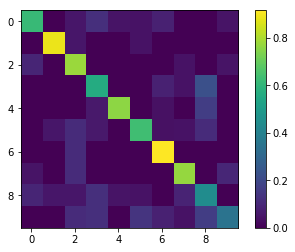

In [83]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat_ts)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[None,:]

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

C:\Users\luoxi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuaracy = 0.625000
[[ 0.478  0.     0.083  0.056  0.     0.158  0.143  0.     0.118  0.071]
 [ 0.     0.842  0.     0.     0.     0.053  0.     0.     0.059  0.071]
 [ 0.043  0.     0.667  0.056  0.     0.053  0.048  0.071  0.     0.143]
 [ 0.087  0.053  0.042  0.556  0.     0.     0.048  0.036  0.118  0.   ]
 [ 0.     0.053  0.042  0.     0.529  0.053  0.     0.036  0.176  0.071]
 [ 0.     0.     0.042  0.056  0.     0.579  0.     0.     0.176  0.214]
 [ 0.087  0.     0.042  0.     0.     0.     0.762  0.     0.     0.143]
 [ 0.     0.105  0.042  0.     0.059  0.     0.     0.786  0.118  0.   ]
 [ 0.     0.053  0.083  0.056  0.     0.105  0.     0.036  0.353  0.286]
 [ 0.     0.     0.083  0.     0.     0.     0.095  0.     0.118  0.571]]




Accuaracy = 0.610000
[[ 0.773  0.     0.056  0.     0.     0.     0.095  0.     0.     0.08 ]
 [ 0.     0.778  0.056  0.045  0.     0.125  0.     0.     0.     0.   ]
 [ 0.     0.056  0.667  0.     0.     0.125  0.     0.118  0.05   0.   ]
 [ 0

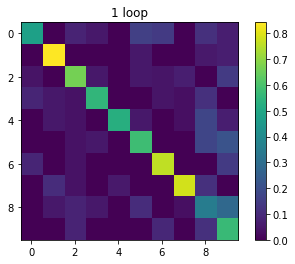

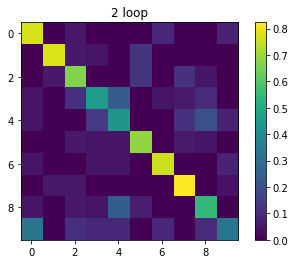

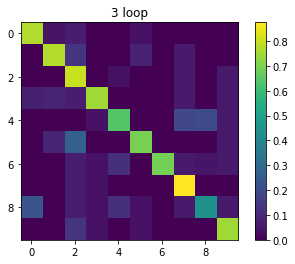

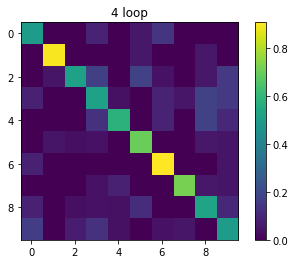

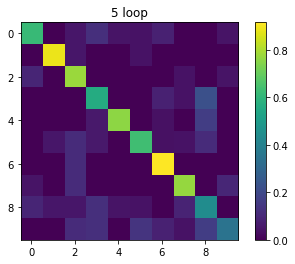

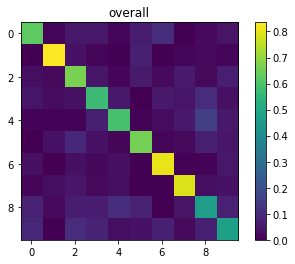

In [80]:
from sklearn import  preprocessing
C_all = np.zeros((10,10))
acc = []
for i in range(5):
    Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=ntr, test_size=nts,shuffle=True)
    Mean_tr = np.mean(Xtr,axis = 0)
    Std_tr = np.std(Xtr,axis = 0)
    Mean_ts = np.mean(Xts,axis = 0)
    Std_ts = np.std(Xts,axis = 0)
    Xtr_scale = (Xtr-Mean_tr[None,:])/Std_tr[None,:]
    Xts_scale = (Xts-Mean_tr[None,:])/Std_tr[None,:]
    
    clf.fit(Xtr_scale, ytr) 
    yhat_ts = clf.predict(Xts_scale)
    acci = np.mean(yhat_ts == yts)
    print('Accuaracy = {0:f}'.format(acci))
    acc.append(acci)
    
    C = confusion_matrix(yts,yhat_ts)
    C_all = C_all+C
    Csum = np.sum(C,1)
    C = C / Csum[None,:]
    print(np.array_str(C, precision=3, suppress_small=True))
    print('\n')
    print('\n')
    plt.figure(i)
    plt.imshow(C, interpolation='none')
    plt.colorbar()
    plt.title('{0:d} loop'.format(i+1))
    
    
nmlz_C = preprocessing.normalize(C_all, axis=1, norm='l1')
accm= np.mean(acc)
print('average accuracy= {0:f}'.format(accm))
print('Normalizerd Confusion Matrix across all folds')
print(np.array_str(nmlz_C, precision=4, suppress_small=True))  
plt.figure(6)
plt.imshow(nmlz_C, interpolation='none')
plt.title('overall')
plt.colorbar()